Project: Predicting stroke patients


Team: Michael Foster

Personal Objectives: I am eager to gain skills sifting through and analyzing a dataset as well as implementing and evaluating a predictive model.

The goal of this analysis is to predict a patient's risk for stroke value. This can be beneficial to both patients and physicians. Patient's would be able to see their own risk value and hopefully would take the necessary measures to keep their risk level as low as they can. Additionally, physicians could quickly calculate and highlight higher risk patients. This could save time and flag patients that may require greater attention.

Immediate drawbacks are the lack of features. The dataset only has 10 independent variables. While the variables may be good predictive indicators, they still might only cover a small amount of the factors that contribute to a patient having a stroke. For instance, the variable "ever_married" does not cover all potential cases - a patient might be actively married, or once married and divorced, or not married but with a life partner. Additionally, more patients, specifically stroke patients, could improve the dataset and its imbalance.

All the variables will all be used in any model building. However, techniques will be required to balance the dataset.

This dataset was acquired from Kaggle - https://www.kaggle.com/fedesoriano/stroke-prediction-dataset 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in dataset
data = pd.read_csv('data/stroke.csv')

In [3]:
# Check size of dataset
print(f'Data Shape: {data.shape}')
# View first few rows
data.head()

Data Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
## Percentage of data each feature has - and seeing what is missing
100 - data.isnull().sum()/data.count()*100

id                   100.00000
gender               100.00000
age                  100.00000
hypertension         100.00000
heart_disease        100.00000
ever_married         100.00000
work_type            100.00000
Residence_type       100.00000
avg_glucose_level    100.00000
bmi                   95.90548
smoking_status       100.00000
stroke               100.00000
dtype: float64

We can see bmi is only 95.91% filled. We can investigate the missing values

In [6]:
# This shows us 201 records are missing BMI data.
data[data['bmi'].isna()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [12]:
# Can drop the NAs from BMI
data.drop(data[data['bmi'].isna()].index, axis=0, inplace=True)
print(data.shape)

(4909, 12)


In [11]:
# How many unique values per feature
data.nunique()

id                   4909
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3852
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

This tells us a few things: First, we see the id column contains no duplicates since every row has its own id. We can remove the id column since it offers no information. Gender has 3 unique values, thus, we should not only assume male/female. Hypertension/heart_disease/ever_married/residence_type/stroke are all binary variables.

In [14]:
# Can drop the ID column
data.drop('id', axis=1, inplace=True)
# View stats on each feature
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Describing the data can tell us some more information about each variable. This function is used for continous numerous variables. We see the 'bmi' range is from 10-97. A BMI of 97 i dont believe is possible to live with. Therefore we are going to filter out any BMIs over 54. 54 is chosen because the NIH offers a BMI table calculation but the table does not extend beyond 54.

Source: https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_tbl2.htm

In [17]:
# Dropping BMI values exceeding 54
index_to_drop = data[data['bmi']>54].index
data.drop(index_to_drop, axis=0, inplace=True)

In [18]:
# Get gender breakdown of dataset
male_pct = data[data['gender']=='Male'].shape[0]/data.shape[0]
female_pct = data[data['gender']=='Female'].shape[0]/data.shape[0]
other_pct = 1 - male_pct - female_pct

Percent of dataset that is male: 41.09%
Percent of dataset that is female: 58.89%
Percent of dataset that does not identify as male/female: 0.02%


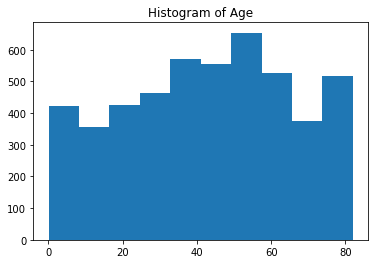

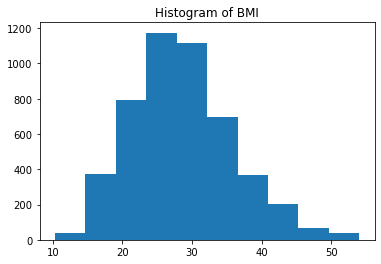

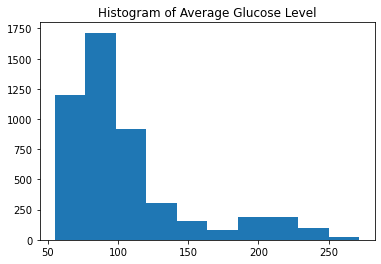

In [19]:
# Check gender percentages
print(f'Percent of dataset that is male: {100*male_pct:.2f}%')
print(f'Percent of dataset that is female: {100*female_pct:.2f}%')
print(f'Percent of dataset that does not identify as male/female: {100*other_pct:.2f}%')

# Check histograms of continuous variables
# Get histogram of age
plt.hist(data['age'])
plt.title('Histogram of Age')
plt.show()

# Get histogram of bmi
plt.hist(data['bmi'])
plt.title('Histogram of BMI')
plt.show()

# Get histogram of avg_glucose_level
plt.hist(data['avg_glucose_level'])
plt.title('Histogram of Average Glucose Level')
plt.show()

In [37]:
# Is the dataset balanced?
stroke_pct = data[data['stroke']==1].shape[0]/data.shape[0]
print(f'Percentage of dataset that had a stroke: {stroke_pct*100:.2f}%')

Percentage of dataset that had a stroke: 4.87%


Because only 5% of the dataset has had a stroke, this dataset is severly imbalanced. This is a common issue in medical data as most people are labeled "healthy". This will be something to note during phase 2 - that the dataset is imbalanced. Tree-based models can avoid imbalance issues, however, any regression based model will require some engineering. Over and under sampling might be useful for this dataset.

Percentages in bar is the percent of dataset


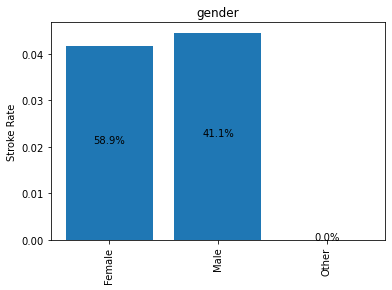

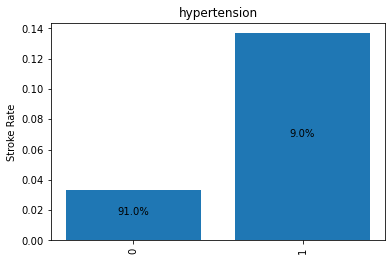

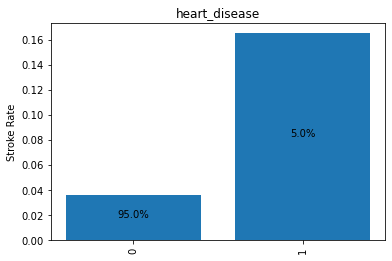

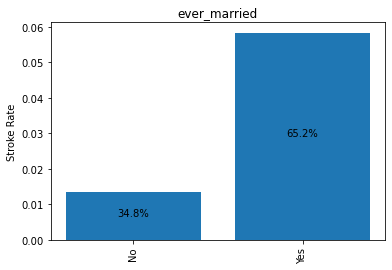

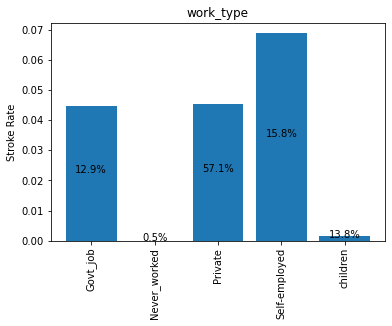

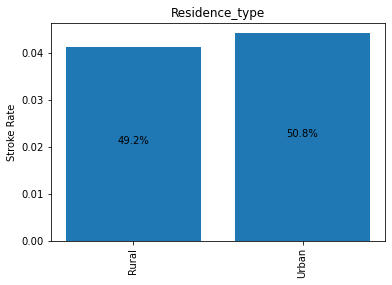

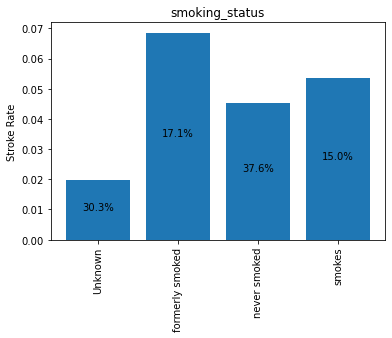

In [20]:
# Plot a univariate analysis for percentage of stroke patients given a specific feature
# The percentage inside the bars represent the percentage of the dataset that contain that feature
def addlabels(x, y, text):
    for i in range(len(x)):
        plt.text(i,y[i]/2,f'{text[i]:.1f}%', ha='center')

categorical = ['gender', 'hypertension', 'heart_disease',
                'ever_married', 'work_type', 'Residence_type',
                'smoking_status']

print('Percentages in bar is the percent of dataset')

for feature in categorical:
    group = data.groupby([feature]).agg({'stroke': ['mean', 'count']})
    total = group['stroke']['count'].sum()
    x = group.index.astype(str).tolist()
    y = group['stroke']['mean']
    text = ((group['stroke']['count']/total)*100).tolist()
    plt.bar(x, group['stroke']['mean'])
    addlabels(x, y, text)
    plt.title(feature)
    plt.xticks(rotation=90)
    plt.ylabel(f'Stroke Rate')
    plt.show()

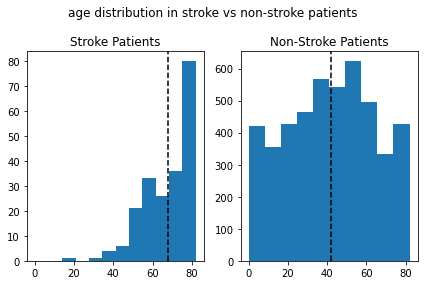

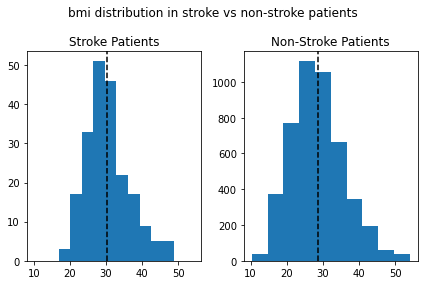

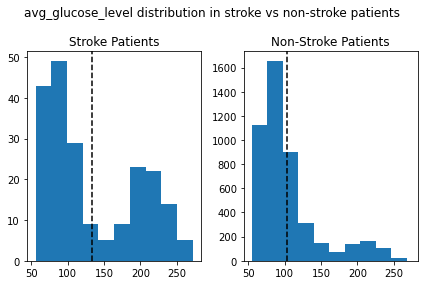

In [59]:
# Plot 
numerical = ['age', 'bmi', 'avg_glucose_level']

for feature in numerical:
    stroke = data[data['stroke']==1][feature]
    non_stroke = data[data['stroke']==0][feature]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)

    # Stroke graph
    ax[0].hist(stroke)
    ax[0].axvline(stroke.mean(), color='k', linestyle='dashed')
    ax[0].title.set_text('Stroke Patients')

    # Non stroke graph
    ax[1].hist(non_stroke)
    ax[1].axvline(non_stroke.mean(), color='k', linestyle='dashed')
    ax[1].title.set_text('Non-Stroke Patients')
    
    fig.suptitle(f'{feature} distribution in stroke vs non-stroke patients')
    fig.tight_layout()
    plt.show()

Above we can see the difference in distributions of the continuous variables in both the stroke and non-stroke population. Each population subset mean is represented by the black dotted line. The most significant difference is noticeable in the age feature. Regardless of its intuition being obvious or not, the data would suggest that the stroke population tends to be older than the non-stroke population. Interestingly enough, the BMI distribution does not have any obvious difference in distribution.